In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline
import statsmodels.api as sm
from datetime import timedelta,datetime

# SH and SDS beta calculation and data preparation

In [2]:
df=pd.read_csv("SH_SDS_data.csv",index_col=0)
df.drop(index=[0],inplace=True)  # remove the first row because the time interval btw row 0 and 1 is not 10 seconds
df.reset_index(drop=True,inplace=True)

In [3]:
def calculate_parameters(df):  # calculate in-sample beta, constant
    df['mid1']=(df.bid1+df.ask1)/2
    df['mid2']=(df.bid2+df.ask2)/2
    
    X = sm.add_constant(df.mid2)
    res = sm.OLS(df.mid1, X).fit()
    constant=res.params[0]
    slope=res.params[1]
    
    predicted_Y=constant+slope*df.mid2
    df['residuals']=df.mid1-predicted_Y
    
    return slope, constant


def prep_data(df, slope, constant, res_num, imb1_num, imb2_num):  # symmetrize data and cut states  
    df_flip=df.copy()
    df_flip.columns=['time', 'ask1', 'ask_size1', 'bid1', 'bid_size1', 'ask2', 'ask_size2', 'bid2', 'bid_size2',
                     'mid1','mid2','residuals']
    df_flip[['ask1', 'bid1', 'ask2', 'bid2','residuals']]=-df_flip[['ask1', 'bid1', 'ask2', 'bid2','residuals']]

    change1=df.bid1[len(df)-1]-df_flip.bid1[0]-0.01
    change2=df.bid2[len(df)-1]-df_flip.bid2[0]-0.01

    df_flip[['ask1', 'bid1']]=df_flip[['ask1', 'bid1']]+change1
    df_flip[['ask2', 'bid2']]=df_flip[['ask2', 'bid2']]+change2
    
    df_flip['mid1']=(df_flip.bid1+df_flip.ask1)/2
    df_flip['mid2']=(df_flip.bid2+df_flip.ask2)/2
    predicted_Y_flip=constant+slope*df_flip.mid2

    df_flip.time=pd.to_datetime(df_flip.time)
    df_flip.time+=timedelta(hours=5)
    
    df.set_index("time",inplace=True)
    df.index = pd.to_datetime(df.index,utc=True)
    df['imb1']=df.bid_size1/(df.bid_size1+df.ask_size1)
    df['imb2']=df.bid_size2/(df.bid_size2+df.ask_size2)
    df2=df[['residuals','mid1','mid2','imb1','imb2']]
    df2.index = df.index.shift(-10,freq='S')
    df2.columns=['residual_later','mid1_later','mid2_later','imb1_later','imb2_later']
    df = pd.merge_asof(df, df2, left_index=True, right_index=True, direction='forward')
    df['pnl'] = df.residual_later-df.residuals  # forward pnl
    df['mid1_diff'] = df.mid1_later-df.mid1
    df['mid2_diff'] = df.mid2_later-df.mid2
    df.dropna(inplace=True)
    
    df_flip.set_index("time",inplace=True)
    df_flip.index = pd.to_datetime(df_flip.index,utc=True)
    df_flip['imb1']=df_flip.bid_size1/(df_flip.bid_size1+df_flip.ask_size1)
    df_flip['imb2']=df_flip.bid_size2/(df_flip.bid_size2+df_flip.ask_size2)
    df2_flip=df_flip[['residuals','mid1','mid2','imb1','imb2']]
    df2_flip.index = df_flip.index.shift(-10,freq='S')# - timedelta(minutes=5)  # data from 5 minutes later
    df2_flip.columns=['residual_later','mid1_later','mid2_later','imb1_later','imb2_later']
    df_flip = pd.merge_asof(df_flip, df2_flip, left_index=True, right_index=True, direction='forward')
    df_flip['pnl'] = df_flip.residual_later-df_flip.residuals  # forward pnl
    df_flip['mid1_diff'] = df_flip.mid1_later-df_flip.mid1
    df_flip['mid2_diff'] = df_flip.mid2_later-df_flip.mid2
    df_flip.dropna(inplace=True)
    
    df=pd.concat([df,df_flip])

    df.index = pd.to_datetime(df.index,utc=True)
    
    df['residual_bucket'] = pd.cut(df['residuals'], res_num, labels=False)
    
    df['imb1']=df.bid_size1/(df.bid_size1+df.ask_size1)
    df['imb2']=df.bid_size2/(df.bid_size2+df.ask_size2)
    df['imb1_bucket'] = pd.cut(df.imb1, imb1_num, labels=False)
    df['imb2_bucket'] = pd.cut(df.imb2, imb2_num, labels=False)
    return df

In [4]:
res_num=6
imb1_num=3
imb2_num=3

In [5]:
slope, constant=calculate_parameters(df)
df=prep_data(df, slope, constant, res_num, imb1_num, imb2_num)

# Cointegration plot

average pnl for 6 residual states are
 residual_bucket
0    0.004148
1    0.001738
2    0.000363
3   -0.000363
4   -0.001738
5   -0.004148
Name: pnl, dtype: float64


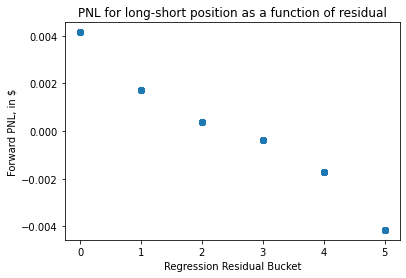

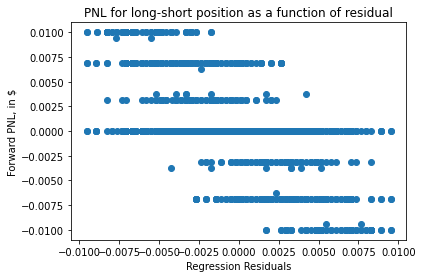

In [6]:
# residual_bucket vs avg_pnl
x1=df.groupby('residual_bucket').pnl.mean()
df=df.assign(avg_pnl=df.residual_bucket.map(x1))

print('average pnl for', res_num, 'residual states are\n', x1)
plt.scatter(df.residual_bucket,df.avg_pnl)
plt.xlabel("Regression Residual Bucket")
plt.ylabel('Forward PNL, in $')
plt.title('PNL for long-short position as a function of residual')
plt.xticks(range(0,res_num))
plt.show()

plt.scatter(df.residuals,df.pnl)
plt.xlabel("Regression Residuals")
plt.ylabel('Forward PNL, in $')
plt.title('PNL for long-short position as a function of residual')
plt.show()

# Method to decide the number of residual buckets

In [7]:
# To find the number of residual buckets, we use the residual_bucket change and price change of each row
# If either price change (more than 1 tick), we think that the residual_bucket should also change since residual indicate
# the price relationship of the two assets.
# We should use enough residual buckets so that our state model is robust enough to uncover all price movement.

df2=pd.read_csv("SH_SDS_data.csv",index_col=0)
df2.drop(index=[0],inplace=True)  # remove the first row because the time interval btw row 0 and 1 is not 10 seconds
df2.reset_index(drop=True,inplace=True)
slope, constant=calculate_parameters(df2)
df2=prep_data(df2, slope, constant, 6, imb1_num, imb2_num)

y=df2.residual_bucket.shift(-1)-df2.residual_bucket
y.dropna(inplace=True)
z1=df2.mid1.shift(-1)-df2.mid1
z2=df2.mid2.shift(-1)-df2.mid2
z=(z1>=0.01)|(z1>=0.01) # more than 1 tick move for either asset
z.dropna(inplace=True)
((y==0)&z).sum() # The smallest number of residual bucket that make this result equal to 0 is 6.

0

# Imbalance plot

G1(I_t) for 3 imbalance states are
              mid1_diff
imb1_bucket           
0             -0.00186
1              0.00000
2              0.00186


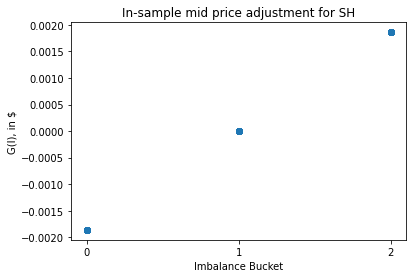

G2(I_t) for 3 imbalance states are
              mid2_diff
imb2_bucket           
0             -0.00251
1              0.00000
2              0.00251


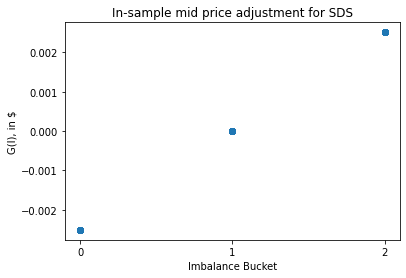

In [8]:
# imb_bucket v.s. G_It
x1=df.groupby('imb1_bucket')[['mid1_diff']].mean()
x2=df.groupby('imb2_bucket')[['mid2_diff']].mean()

df=df.assign(G1_It=df.imb1_bucket.map(x1.mid1_diff),G2_It=df.imb2_bucket.map(x2.mid2_diff))

df.dropna(inplace=True)

print('G1(I_t) for',imb1_num,'imbalance states are\n', x1)
plt.scatter(df.imb1_bucket,df.G1_It)
plt.xlabel("Imbalance Bucket")
plt.ylabel('G(I), in $')
plt.title('In-sample mid price adjustment for SH')
plt.xticks(range(0,imb1_num))
plt.show()

print('G2(I_t) for',imb2_num,'imbalance states are\n', x2)
plt.scatter(df.imb2_bucket,df.G2_It)
plt.xlabel("Imbalance Bucket")
plt.ylabel('G(I), in $')
plt.title('In-sample mid price adjustment for SDS')
plt.xticks(range(0,imb2_num))
plt.show()

In [9]:
# imb1
df2=pd.read_csv("SH_SDS_data.csv",index_col=0)
df2.drop(index=[0],inplace=True)  # remove the first row because the time interval btw row 0 and 1 is not 10 seconds
df2.reset_index(drop=True,inplace=True)
slope, constant=calculate_parameters(df2)
df2=prep_data(df2, slope, constant, res_num, 50, 3)

y=df2.imb1_bucket.shift(-1)-df2.imb1_bucket
y.dropna(inplace=True)
z1=df2.mid1.shift(-1)-df2.mid1
z=(z1>=0.01) # more than 1 tick move for either asset
z.dropna(inplace=True)
((y==0)&z).sum() # The smallest number of residual bucket that make this result equal to 0 is 6.

0

In [10]:
# imb2
df2=pd.read_csv("SH_SDS_data.csv",index_col=0)
df2.drop(index=[0],inplace=True)  # remove the first row because the time interval btw row 0 and 1 is not 10 seconds
df2.reset_index(drop=True,inplace=True)
slope, constant=calculate_parameters(df2)
df2=prep_data(df2, slope, constant, res_num, 3, 40)

y=df2.imb2_bucket.shift(-1)-df2.imb2_bucket
y.dropna(inplace=True)
z1=df2.mid2.shift(-1)-df2.mid2
z=(z2>=0.01) # more than 1 tick move for either asset
z.dropna(inplace=True)
((y==0)&z).sum() # The smallest number of residual bucket that make this result equal to 0 is 6.

2

In [11]:
df

,bid1,bid_size1,ask1,ask_size1,bid2,bid_size2,ask2,ask_size2,mid1,mid2,...,imb2_later,pnl,mid1_diff,mid2_diff,residual_bucket,imb1_bucket,imb2_bucket,avg_pnl,G1_It,G2_It
time,,,,,,,,,,,,,,,,,,,,,
2020-11-23 15:41:49.108311+00:00,18.95,8018,18.96,8288,13.79,2527,13.80,1007,18.955,13.795,...,0.526113,0.003125,0.01,0.01,3,1,2,-0.000363,0.00000,0.00251
2020-11-23 15:41:59.133980+00:00,18.96,4966,18.97,12651,13.80,2327,13.81,2096,18.965,13.805,...,0.608324,0.000000,0.00,0.00,4,0,1,-0.001738,-0.00186,0.00000
2020-11-23 15:42:09.142515+00:00,18.96,3938,18.97,11870,13.80,2850,13.81,1835,18.965,13.805,...,0.457413,-0.006875,0.00,0.01,4,0,1,-0.001738,-0.00186,0.00000
2020-11-23 15:42:19.159326+00:00,18.96,7238,18.97,7922,13.81,2320,13.82,2752,18.965,13.815,...,0.622822,0.006875,0.00,-0.01,1,1,1,0.001738,0.00000,0.00000
2020-11-23 15:42:29.175628+00:00,18.96,4987,18.97,11532,13.80,3324,13.81,2013,18.965,13.805,...,0.761670,-0.006875,0.00,0.01,4,0,1,-0.001738,-0.00186,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24 01:40:49.099436+00:00,18.94,10499,18.95,5860,13.78,1614,13.79,3272,18.945,13.785,...,0.331618,0.000000,0.00,0.00,1,1,0,0.001738,0.00000,-0.00251
2020-11-24 01:40:59.119396+00:00,18.94,10499,18.95,5384,13.78,1611,13.79,3247,18.945,13.785,...,0.322496,0.000000,0.00,0.00,1,1,0,0.001738,0.00000,-0.00251
2020-11-24 01:41:09.140091+00:00,18.94,10584,18.95,3649,13.78,1478,13.79,3105,18.945,13.785,...,0.261832,0.000000,0.00,0.00,1,2,0,0.001738,0.00186,-0.00251


In [12]:
df.to_csv('SH_SDS_data_2.csv')

In [13]:
df.columns

Index(['bid1', 'bid_size1', 'ask1', 'ask_size1', 'bid2', 'bid_size2', 'ask2',
       'ask_size2', 'mid1', 'mid2', 'residuals', 'imb1', 'imb2',
       'residual_later', 'mid1_later', 'mid2_later', 'imb1_later',
       'imb2_later', 'pnl', 'mid1_diff', 'mid2_diff', 'residual_bucket',
       'imb1_bucket', 'imb2_bucket', 'avg_pnl', 'G1_It', 'G2_It'],
      dtype='object')